In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

sns.set(font_scale=1.05)  
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid", {'axes.grid' : False})
# plt.rcParams.update({'font.family':'Times New Roman'})
# plt.rcParams.update({'font.family':'fantasy'})



This notebook is for exploring the icd9 diagnosis codes data in Mimic-III and how we translated this into a ICD9 50 and Triage tasks.

## All icd9 codes 
 look at all notes data and get counts of each etc

In [4]:
# data directory
data_dir = "../mimic3-icd9-data/intermediary-data/"


In [5]:
# first lets check the creation of top n icd9 code datasets

def get_topN_mimic_data(path, save_dir, modes = ["train","validate","test"],n_labels = -1):
    """ Reads a comma separated value file.

    :param path: path to a csv file.
            save_dir: path to save filtered data
            n_labels: number of top icd9 codes to subset - use -1 for all
    
    :return: List of records as dictionaries
    """

    # we need training data first to get all codes
    assert modes[0] is "train"
    # can create a dataset to return
    dataset = {}
    #run through each provided data mode or set i.e. train/valid/test files   
    for mode in tqdm(modes):    
        # read in the processed training data with all icd9 codes 
        df = pd.read_csv(f"{path}/notes2diagnosis-icd-{mode}.csv")
        df = df[["TEXT", "ICD9_CODE"]]
        
        # get the top N codes based on frequency in train data
        if mode == "train":
                top_codes = df['ICD9_CODE'].value_counts()[:n_labels].index.tolist()         
                print(f"number of codes: {len(top_codes)}")
        # rename columns
        df = df.rename(columns={'TEXT':'text', 'ICD9_CODE':'label'}) 
        # subset based on icd9 code being in top N
        df = df[df['label'].isin(top_codes)]
        df["text"] = df["text"].astype(str)
        df["label"] = df["label"].astype(str)

        
        if save_dir is not None:    
               
            print(f"Saving {mode} file at: {save_dir}/top_{n_labels}_icd9/{mode}.csv")
            if not os.path.exists(f"{save_dir}/top_{n_labels}_icd9"):
                os.makedirs(f"{save_dir}/top_{n_labels}_icd9")

            df.to_csv(f'{save_dir}/top_{n_labels}_icd9/{mode}.csv', index= None)
        # assign to dataset
        dataset[mode] = df
    return dataset

In [6]:
# we can see we get 2106 unique icd9 codes
all_icd9_data = get_topN_mimic_data(path = data_dir, save_dir =None , n_labels=-1)

 33%|███▎      | 1/3 [00:01<00:03,  1.75s/it]

number of codes: 2106


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


In [7]:
# now we actually want to concatenate all of these to take a peak at all data
concat_all_icd9_data = pd.concat(all_icd9_data.values(), ignore_index= True)

In [11]:
concat_all_icd9_data.head()

,text,label
0,: : : Sex: F Service: MEDICINE Allergies: Sulf...,44023
1,: : : Sex: F Service: CARDIOTHORACIC Allergies...,4240
2,: : : Sex: M Service: NBB HISTORY OF PRESENT I...,7746
3,: : : Sex: F Service: NEONATOLOGY HISTORY: wee...,V3001
4,: : : Sex: M Service: CARDIOTHORACIC Allergies...,3963


In [12]:
# look at top 10 label value counts
concat_all_icd9_data.label.value_counts()[:10]

41401    3455
0389     1748
41071    1636
V3001    1313
4241     1133
51881    1032
V3000     890
V3101     823
431       765
4240      558
Name: label, dtype: int64

In [17]:
# too many to plot really - as we can see

# concat_all_icd9_data.label.value_counts().plot(kind="bar")


## ICD9 50

# we can either use the function above or read in the already created top 50 data 

In [8]:
def get_all_icd9_50(data_dir, modes = ["train","valid","test"]):
    dataset = {}
    for mode in modes:
        dataset[mode] = pd.read_csv(f"{data_dir}/top_50_icd9/{mode}.csv")
    
    # now we actually want to concatenate all of these to take a peak at all data
    all_data = pd.concat(dataset.values(), ignore_index= True)

    return all_data

In [9]:
all_top50_data = get_all_icd9_50(data_dir)


In [38]:
all_top50_data.head()

,text,label,Unnamed: 0
0,: : : Sex: F Service: CARDIOTHORACIC Allergies...,4240,NaN
1,: : : Sex: F Service: NEONATOLOGY HISTORY: wee...,V3001,NaN
2,: : : Sex: M Service: CARDIOTHORACIC Allergies...,41041,NaN
3,: : : Sex: F Service: MEDICINE Allergies: Peni...,51881,NaN
4,: : : Sex: F Service: CARDIOTHORACIC Allergies...,3962,NaN


In [42]:
# now we can calculate percentage of the all data made up by the top 50 diagnosis codes

all_top50_data.shape[0]/concat_all_icd9_data.shape[0]

0.5145679332555224

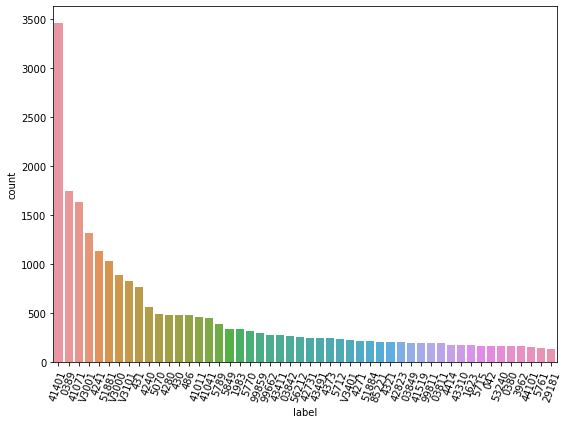

In [10]:
sns.countplot(x ="label", data = all_top50_data, order = all_top50_data.label.value_counts().index)

plt.xticks(rotation=70);
plt.savefig("./results/figures/icd9_top50_counts.pdf")

## Triage task

In [11]:
# set data_dir
# load in the icd9 triage groupings for the top 20 icd9 codes

icd9_grouped = pd.read_csv(f"{data_dir}/triage/top_20_icd9_w_counts_descriptions_grouped.csv", index_col=None)



In [20]:
icd9_grouped.shape

(20, 4)

In [ ]:
icd9_grouped.groupby("Triage (post-icu) ")

In [12]:
# Can load in our already formatted training data

def get_formatted_triage_data(modes = ["train","validate","test"], data_dir = None):

    '''
    Function to read in and combined triage data to get frequencies of each group etc.

    args: Data dir -> where is the data right now
    '''

    # empty list to fill with each df
    dfs = [] 

    for mode in modes:

        df = pd.read_csv(f"{data_dir}/{mode}.csv")

        dfs.append(df)

    return pd.concat(dfs)

 
    

In [13]:
triage_data = get_formatted_triage_data(data_dir = "../mimic3-icd9-data/intermediary-data/triage/")

In [23]:
triage_data.head()

,text,label,triage-category
0,: : : Sex: F Service: CARDIOTHORACIC Allergies...,4240,Cardiology
1,: : : Sex: F Service: NEONATOLOGY HISTORY: wee...,V3001,Obstetrics
2,: : : Sex: M Service: CARDIOTHORACIC Allergies...,41041,Cardiology
3,: : : Sex: F Service: MEDICINE Allergies: Peni...,51881,Respiratory
4,: : : Sex: M Service: ADMISSION DIAGNOSIS: . S...,41401,Cardiology


In [11]:
triage_data.shape

(15845, 3)

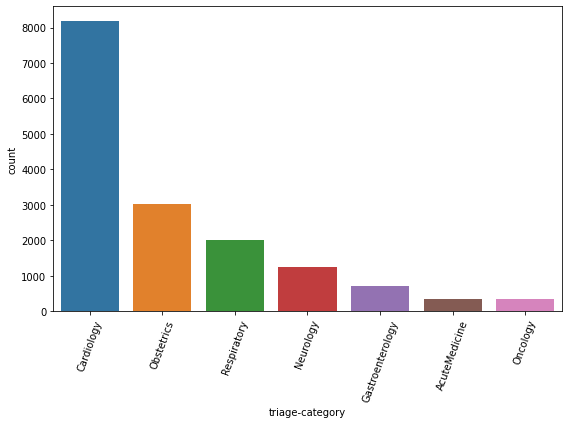

In [15]:
# value counts plot
# plt.figure(figsize=(10,8))

sns.countplot(x ="triage-category", data = triage_data, order = triage_data['triage-category'].value_counts().index)

plt.xticks(rotation=70);
plt.tight_layout()
plt.savefig("../plot_scripts/results/figures/triage_distribution.pdf")

## Now look at mortality and length of stay

In [14]:
data_dir = "../clinical-outcomes-data/mimic3-clinical-outcomes/"

In [15]:
# quick function to concat all clinical outcomes data

def combine_outcomes_data(data_dir, task = "mp", modes = ["train","valid","test"]):
    
    assert task is "mp" or task is "los"
    dataset = {}
    for mode in tqdm(modes):
        dataset[mode] = pd.read_csv(f"{data_dir}/{task}/{mode}.csv")

    # concat together
    all_data = pd.concat(dataset.values(), ignore_index=True)

    return all_data


Mortality

In [16]:
# mortality
mort_data = combine_outcomes_data(data_dir)

100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


In [24]:
mort_data.head()

,id,text,hospital_expire_flag
0,107384,"CHIEF COMPLAINT: AMS, concern for toxic alcoho...",0
1,101061,CHIEF COMPLAINT: abdominal pain\n\nPRESENT ILL...,0
2,127180,CHIEF COMPLAINT: Bilateral Sub Dural Hematoma\...,0
3,168339,CHIEF COMPLAINT: Intracranial bleed\n\nPRESENT...,0
4,154044,CHIEF COMPLAINT: ischemic left foot\n\nPRESENT...,0


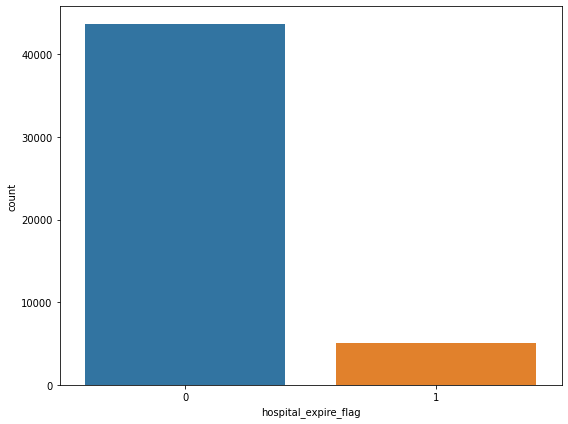

In [26]:
sns.countplot(x ="hospital_expire_flag", data = mort_data, order = mort_data["hospital_expire_flag"].value_counts().index)

# plt.xticks(rotation=70);
plt.tight_layout()
plt.savefig("./results/figures/mortality_distribution.pdf")

Length of stay



In [17]:
los_data = combine_outcomes_data(data_dir, task = "los")

100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


In [31]:
los_data.head()

,id,text,los_label
0,155297,CHIEF COMPLAINT: Decreased responsiveness Maj...,0
1,168150,"CHIEF COMPLAINT: Fatigue, wide complex tachyca...",1
2,154015,CHIEF COMPLAINT: preop CABG\n\nPRESENT ILLNESS...,2
3,145268,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This is ...,1
4,170521,CHIEF COMPLAINT: worsening shortness of breath...,2


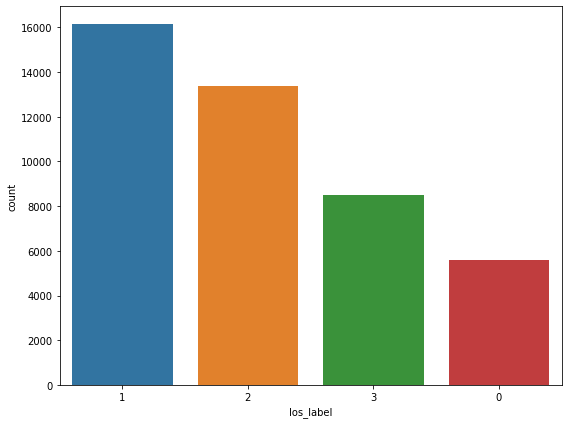

In [32]:
sns.countplot(x ="los_label", data = los_data, order = los_data["los_label"].value_counts().index)

# plt.xticks(rotation=70);
plt.tight_layout()
plt.savefig("./results/figures/los_distribution.pdf")

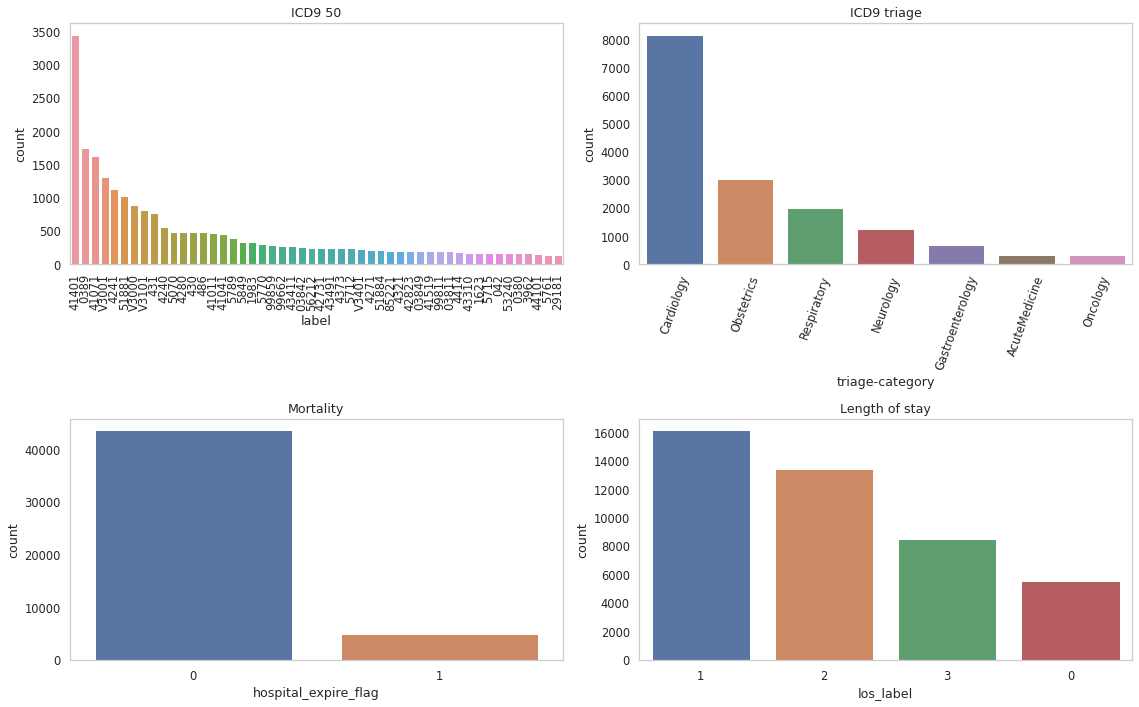

In [38]:
# all plots on one

plt.rcParams["figure.figsize"] = [16, 10]
f, axes = plt.subplots(2, 2)

# axes 0, 0 plot
sns.countplot(x ="label", data = all_top50_data, order = all_top50_data.label.value_counts().index, ax = axes[0,0])
axes[0,0].set_title("ICD9 50")
axes[0,0].tick_params(axis ='x', rotation = 90)
plt.tight_layout()


# axes 0, 1
sns.countplot(x ="triage-category", data = triage_data, order = triage_data['triage-category'].value_counts().index, ax = axes[0,1])
axes[0,1].set_title("ICD9 triage")
axes[0,1].tick_params(axis ='x', rotation = 70)
plt.tight_layout()

# axes 1, 0 
sns.countplot(x ="hospital_expire_flag", data = mort_data, order = mort_data["hospital_expire_flag"].value_counts().index, ax = axes[1,0])
axes[1,0].set_title("Mortality")
plt.tight_layout()
# axes 1, 1
sns.countplot(x ="los_label", data = los_data, order = los_data["los_label"].value_counts().index, ax = axes[1,1])
axes[1,1].set_title("Length of stay")
plt.tight_layout()

# save
plt.savefig(f"./results/figures/all_task_distributions.pdf")